In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import re

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/genes_for_clustering.csv')

In [5]:
df.head()

,GeneID,desc_length,chromosome,arm_encoded,chrom_encoded,type_biological-region,type_ncRNA,type_other,type_protein-coding,type_pseudo,type_rRNA,type_scRNA,type_snRNA,type_snoRNA,type_tRNA,type_unknown,Symbol,type_of_gene,description
0,1,-0.881502,1.584148,0.702056,1.322565,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,A1BG,protein-coding,alpha-1-B glycoprotein
1,2,-0.963013,0.429485,-1.407337,0.284440,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,A2M,protein-coding,alpha-2-macroglobulin
2,9,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NAT1,protein-coding,N-acetyltransferase 1
3,10,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NAT2,protein-coding,N-acetyltransferase 2
4,11,-0.229413,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,-0.628461,1.777636,-0.02635,-0.007526,-0.046444,-0.131086,-0.085961,-0.12752,NATP,pseudo,N-acetyltransferase pseudogene


In [6]:
categorical_maps = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    categorical_maps[col] = dict(zip(le.transform(le.classes_), le.classes_))
print(categorical_maps)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
#Elle enregistre l’objet Python categorical_maps (un dictionnaire contenant les correspondances entre les valeurs numériques et les catégories d’origine) dans un fichier nommé "categorical_maps.pkl".
joblib.dump(categorical_maps, "/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/categorical_maps.pkl")

['/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/categorical_maps.pkl']

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
joblib.dump(scaler, "/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/scaler.pkl")

['/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/scaler.pkl']

In [10]:
def gap_statistic(X, n_refs=20, max_clusters=10):
    gaps = np.zeros(max_clusters-1)
    for k in range(1, max_clusters):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertia_k = kmeans.inertia_

        # Générer des données de référence uniformes
        ref_inertia = np.zeros(n_refs)
        for i in range(n_refs):
            random_data = np.random.rand(*X.shape)  # Données de référence aléatoires
            kmeans_ref = KMeans(n_clusters=k)
            kmeans_ref.fit(random_data)
            ref_inertia[i] = kmeans_ref.inertia_

        # Calculer la statistique Gap
        gaps[k-1] = np.log(np.mean(ref_inertia)) - np.log(inertia_k)

    # Trouver le "gap" maximal
    optimal_k = np.argmax(gaps) + 1
    return optimal_k

# Utiliser la Gap Statistic
optimal_clusters = gap_statistic(df)
print(f"Le nombre optimal de clusters est : {optimal_clusters}")

Le nombre optimal de clusters est : 9


In [11]:
kmeans = KMeans(optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df["cluster"] = clusters
joblib.dump(kmeans, "/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/kmeans_model.pkl")

['/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/kmeans_model.pkl']

In [12]:
X_2d = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
df["tsne-1"] = X_2d[:, 0]
df["tsne-2"] = X_2d[:, 1]
df.to_csv("/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/clustered_data.csv", index=False)

In [13]:
df_cluster = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/projet_bio_info/data/clustered_data.csv")

In [14]:
df_cluster.head()

,GeneID,desc_length,chromosome,arm_encoded,chrom_encoded,type_biological-region,type_ncRNA,type_other,type_protein-coding,type_pseudo,...,type_snRNA,type_snoRNA,type_tRNA,type_unknown,Symbol,type_of_gene,description,cluster,tsne-1,tsne-2
0,1,-0.881502,1.584148,0.702056,1.322565,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,...,-0.046444,-0.131086,-0.085961,-0.12752,1,3,27893,5,13.081621,82.44946
1,2,-0.963013,0.429485,-1.407337,0.284440,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,...,-0.046444,-0.131086,-0.085961,-0.12752,4,3,27896,5,33.459053,-44.57817
2,9,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,...,-0.046444,-0.131086,-0.085961,-0.12752,48308,3,9875,1,64.678690,-25.29716
3,10,-0.963013,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,1.591189,-0.562545,...,-0.046444,-0.131086,-0.085961,-0.12752,48312,3,9879,1,64.678310,-25.29717
4,11,-0.229413,-0.230323,-1.407337,-0.308775,-0.3855,-0.645132,-0.10092,-0.628461,1.777636,...,-0.046444,-0.131086,-0.085961,-0.12752,48318,4,9885,6,62.225030,-81.04591


<Figure size 1000x600 with 0 Axes>

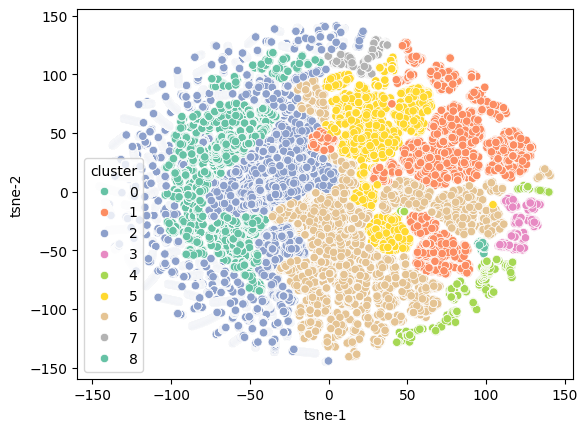

In [17]:
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.scatterplot(data=df_cluster, x="tsne-1", y="tsne-2", hue="cluster", palette="Set2", ax=ax)
plt.show()

In [18]:
#  ÉVALUATION DU CLUSTERING (interne)
silhouette = silhouette_score(X_scaled, clusters)
print("\n Évaluation du modèle de clustering :")

if silhouette < 0.2:
    print(f"Silhouette Score : {silhouette:.3f}  ( Mauvais regroupement)")
if silhouette < 0.5 and silhouette > 0.2 :
    print(f"Silhouette Score : {silhouette:.3f}  (Moyenne séparation )")
if silhouette > 0.5:
    print(f"Silhouette Score : {silhouette:.3f}  (Bonne séparation )")




 Évaluation du modèle de clustering :
Silhouette Score : 0.326  (Moyenne séparation )
